Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime as dt
from sklearn import * 
% matplotlib inline

data = pd.read_csv(r'C:\Users\anhem44\Desktop\Capstone 2\properties_2016.csv',index_col='parcelid')
y_data = pd.read_csv(r'C:\Users\anhem44\Desktop\Capstone 2\train_2016_v2.csv',index_col='parcelid')

C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "i

Divide data into clean data, categorical & continuous data with NaNs that need to be predicted

In [2]:
#Step 1
def clean_x(x) :
    #seperate data into frames based off of type
    
    cat_data = x[['architecturalstyletypeid','buildingqualitytypeid','numberofstories']]

    cont_data = x[['structuretaxvaluedollarcnt','censustractandblock','lotsizesquarefeet','finishedsquarefeet50',
                  'finishedsquarefeet15','finishedsquarefeet12','calculatedfinishedsquarefeet','finishedfloor1squarefeet']]

    others = x.drop(x[['architecturalstyletypeid','buildingqualitytypeid','numberofstories',
                         'calculatedbathnbr','structuretaxvaluedollarcnt','censustractandblock','lotsizesquarefeet',
                         'finishedsquarefeet50','finishedsquarefeet15','finishedsquarefeet12','calculatedfinishedsquarefeet',
                         'finishedfloor1squarefeet']], axis = 1)

    others.fillna(0, inplace=True)
    others.head()

    data_list = others.select_dtypes(include=['object']) # list all non-numeric rows
    numeric_only = others._get_numeric_data() #select only numeric rows

    for column in data_list : #make sure all non-numerics are strings
        data_list[column] = data_list[column].astype(str)

    data_list = data_list.apply(preprocessing.LabelEncoder().fit_transform) #encode all nun-numerics using labels
    numeric_only = numeric_only.apply(preprocessing.LabelEncoder().fit_transform)
    data_clean = pd.concat([numeric_only, data_list], axis=1,join_axes=[x.index]) #re-join numeric and non-numeric
    
    return cat_data, cont_data, data_clean

Predict categorical variables

In [3]:
#step 2
def cat_nan(cat_data,data_clean):
    #use list of names for for loop
    cat_list = list(cat_data) #turn column names into a list
    
    #dfs function will fill and return
    cat_df = pd.DataFrame(index=data_clean.index) #will fill this df w/best prediction answer in a column
    cat_nan_df = pd.DataFrame(columns=['KNN_mean','LGR_mean','RF_mean','best']) #df that will give the score and best 
    
    for i in cat_list :
        # 1- select only those cells w/values for training set
        df_c = pd.concat([data_clean, cat_data[i]],axis=1,join_axes=[data_clean.index]) #join cat data to clean data
        
        df_n_null = df_c[i].notnull() #data that is not null for training set
        df_n_null = df_c[df_n_null]
        df_null = df_c[i].isnull() #data that is null for prediction set
        df_null = df_c[df_null]
        
        y = pd.DataFrame(df_n_null[i]) #target as df
        x = df_n_null.drop(i,axis=1) #remove target from testing set as df
        
        y = y.apply(preprocessing.LabelEncoder().fit_transform) #preproccess target
        
        # 2- Use kfolds for test
        kfold = cross_validation.KFold(len(x),n_folds=5, random_state=42)
        
        # 3- run different tests
        #KNN on test data
        KNN_pred_error = []
        for train, test in kfold :
            x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test] 
            KNN = neighbors.KNeighborsClassifier() 
            KNN.fit(x_train,y_train)
            KNN_score = KNN.score(x_test,y_test)
            KNN_pred_error.append(KNN_score)
        KNN_mean = np.mean(KNN_pred_error) #mean of each score
        
        #logistic regression on test data
        LGR_pred_error = []
        for train, test in kfold :
            x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
            LGR = linear_model.LogisticRegression()
            LGR.fit(x_train,y_train)
            LGR_score = LGR.score(x_test,y_test)
            LGR_pred_error.append(LGR_score)
        LGR_mean = np.mean(LGR_pred_error)
        
        #random forest
        RF_pred_error = []
        for train, test in kfold :
            x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
            RF = ensemble.RandomForestClassifier()
            RF.fit(x_train,y_train)
            RF_score = RF.score(x_test,y_test)
            RF_pred_error.append(RF_score)
        RF_mean = np.mean(RF_pred_error)
        
        # 4-calculate best predictor
        
        best = str() #will tag best predictor
        if (KNN_mean != LGR_mean) & (KNN_mean != RF_mean) & (LGR_mean != RF_mean) :
            if (KNN_mean > LGR_mean) & (KNN_mean > RF_mean) :
                best = 'KNN' 
            elif (LGR_mean > KNN_mean) & (LGR_mean > RF_mean) :
                best = 'LGR'
            elif (RF_mean > LGR_mean) & (RF_mean > KNN_mean) :
                best = 'RF'
        elif KNN_mean == LGR_mean :
            best = 'LGR' 
        elif KNN_mean == RF_mean :
            best = 'KNN'
        else :
            best = 'LGR'
        
        # add to df
        cat_nan_df.loc[i] = [KNN_mean,LGR_mean,RF_mean,best] #add all means and best to df
        
        # 5- use best predictor to predict missing values for predictor set
        x_null = df_null.drop(i,axis=1)
        
        if best == 'KNN':
            KNN = neighbors.KNeighborsClassifier()
            KNN.fit(x,y)
            prediction = KNN.predict(x_null) 
        elif best == 'LGR':
            LGR = linear_model.LogisticRegression()
            LGR.fit(x,y)
            prediction = LGR.predict(x_null)
        elif best == 'RF':
            RF = ensemble.RandomForestClassifier()
            RF.fit(x,y)
            prediction = RF.predict(x_null)
        
        # 6-insert prediction into data
        predicton_df = pd.DataFrame(index=x_null.index)
        x_total = pd.DataFrame()
        
        predicton_df[i] = prediction
        
        x_total = pd.concat([predicton_df,y]) #combine prediction and test set
        cat_df = pd.concat([cat_df, x_total], axis=1) #add complete column to df
        
    return cat_nan_df, cat_df

Use the same procedure for continuous data

In [4]:
#step 3

#select only those cells w/values
def lin_nan(cont_data,data_clean):
    #use list of names for for loop
    lin_list = list(cont_data)
    
    #dfs function will fill and return
    lin_df = pd.DataFrame(index=data_clean.index) #will fill this df w/best prediction answer in a column
    lin_nan_df = pd.DataFrame(columns=['LR_mean','SV_mean','RF_mean','best'])#df that will give the score and best 
    
    for i in lin_list :
        df_c = pd.concat([data_clean, cont_data[i]],axis=1,join_axes=[data_clean.index]) #join cont data to clean data
        
        df_n_null = df_c[i].notnull() #data that is not null for training set
        df_n_null = df_c[df_n_null]
        df_null = df_c[i].isnull() #data that is null for prediction set
        df_null = df_c[df_null]
        
        y = pd.DataFrame(df_n_null[i]) #target as df
        x = df_n_null.drop(i,axis=1) #remove target from testing set as df
        
        y = y.apply(preprocessing.LabelEncoder().fit_transform) #preproccess target
        
        #2- use kfold crossvalidation
        #Use kfolds for test
        kfold = cross_validation.KFold(len(x),n_folds=5, random_state=42)
        
        # 3- run different tests
        #linear regression
        LR_pred_error = []
        for train, test in kfold :
            x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
            LR = linear_model.LinearRegression()
            LR.fit(x_train,y_train)
            LR_score = LR.score(x_test,y_test)
            LR_pred_error.append(LR_score)
        LR_mean = np.mean(LR_pred_error) #mean of each score
        
        #SVM
        SV_pred_error = []
        for train, test in kfold :
            x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
            SV = svm.LinearSVR()
            SV.fit(x_train,y_train)
            SV_score = SV.score(x_test,y_test)
            SV_pred_error.append(SV_score)
        SV_mean = np.mean(SV_pred_error)
        
        #random forest
        RF_pred_error = []
        for train, test in kfold :
            x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test]
            RF = ensemble.RandomForestRegressor()
            RF.fit(x_train,y_train)
            RF_score = RF.score(x_test,y_test)
            RF_pred_error.append(RF_score)
        RF_mean = np.mean(RF_pred_error)
        
        #4- calculate best predictor
        best = str()
        if (LR_mean != SV_mean) & (LR_mean != RF_mean) & (SV_mean != RF_mean) :
            if (LR_mean > SV_mean) & (LR_mean > RF_mean) :
                best = 'LR'
            elif (SV_mean > LR_mean) & (SV_mean > RF_mean) :
                best = 'SV'
            elif (RF_mean > SV_mean) & (RF_mean > LR_mean) :
                best = 'RF'
        elif LR_mean == SV_mean :
            best = 'SV'
        elif LR_mean == RF_mean :
            best = 'KNN'
        else :
            best = 'SV'
        
        #add to df
        lin_nan_df.loc[i] = [LR_mean,SV_mean,RF_mean,best]
        
        #use best predictor to predict missing values
        x_null = df_null.drop(i,axis=1)
        
        # 5- use best predictor to predict missing values for predictor set
        if best == 'LR':
            LR = linear_model.LinearRegression()
            LR.fit(x,y)
            prediction = LR.predict(x_null) 
        elif best == 'SV':
            SV = svm.LinearSVR()
            SV.fit(x,y)
            prediction = LGR.predict(x_null)
        elif best == 'RF':
            RF = ensemble.RandomForestRegressor()
            RF.fit(x,y)
            prediction = RF.predict(x_null)
        
        #6-insert prediction into data
        predicton_df = pd.DataFrame(index=x_null.index)
        x_total = pd.DataFrame()
        
        predicton_df[i] = prediction
        
        x_total = pd.concat([predicton_df,y])
        lin_df = pd.concat([lin_df, x_total], axis=1)
        
    return lin_nan_df, lin_df

Combine data into one frame and split out training data

In [5]:
#step 4
def final_comb(data_clean,lin_pred,cat_pred):    
    final_df = pd.concat([data_clean,lin_pred, cat_pred], axis=1) #combine all three
    
    train_data = pd.concat([y_data, final_df], axis=1,join_axes=[y_data.index]) #join on transaction's parcel ID
    train_data['transactiondate'] = pd.to_datetime(train_data['transactiondate']) #make transdate a datetime
    train_data['year'] = train_data['transactiondate'].dt.year #extract year
    train_data['month']  = train_data['transactiondate'].dt.month #extract month
    train_data['parcelid'] = train_data.index #make a coulumn out of the index
    train_data.set_index(['parcelid','transactiondate'], inplace=True) #reset index
    
    return train_data, final_df

Run all formulas

In [6]:
cat_data, cont_data, data_clean = clean_x(data)
print("clean done")
lin_info, lin_pred = lin_nan(cont_data,data_clean)
print("lin done")
cat_info, cat_pred = cat_nan(cat_data,data_clean)
print("cat done")
final_train, final_df = final_comb(data_clean,lin_pred,cat_pred)
print("fin done")
final_df.to_csv(r'C:\Users\anhem44\Desktop\Capstone 2\zillow_train.csv')
final_train.to_csv(r'C:\Users\anhem44\Desktop\Capstone 2\zillow_final.csv')
print("export done")

C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


clean done


C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

lin done


C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\anhem44\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

cat done
fin done
export done


Check the functions results

In [27]:
lin_info

,LR_mean,SV_mean,RF_mean,best
structuretaxvaluedollarcnt,0.886787,0.745526,0.998714,RF
censustractandblock,0.996779,0.996637,0.999448,RF
lotsizesquarefeet,0.393457,-0.413261,0.940742,RF
finishedsquarefeet50,0.498500,-0.289690,0.830964,RF
finishedsquarefeet15,0.595629,-0.237348,0.776869,RF
finishedsquarefeet12,0.765353,-0.012208,0.891442,RF
calculatedfinishedsquarefeet,0.700614,0.256692,0.878971,RF
finishedfloor1squarefeet,0.509065,-0.064494,0.853631,RF


In [28]:
cat_info

,KNN_mean,LGR_mean,RF_mean,best
architecturalstyletypeid,0.858438,0.866357,0.861571,LGR
buildingqualitytypeid,0.811092,0.708844,0.918914,RF
numberofstories,0.764357,0.687398,0.919020,RF


Cross validate final training data prior to optimzation for a baseline

In [7]:
target = final_train['logerror'] #pull y from training data
final_train_2 = final_train.drop(final_train[['logerror']],axis=1) 

kfold = cross_validation.KFold(len(final_train_2),n_folds=5, random_state=42) #kfold

RF_pred_error = [] #store errors
for train, test in kfold :
    x_train, x_test, y_train, y_test = final_train_2.iloc[train], final_train_2.iloc[test], target[train], target[test]
    RF = ensemble.RandomForestRegressor() #best performer on factors
    RF.fit(x_train,y_train)
    y_pred = RF.predict(x_test)
    RF_MSE = metrics.mean_squared_error(y_test,y_pred) #check mse
    RF_pred_error.append(RF_MSE) #append
RF_mean = np.mean(RF_pred_error) #mean of all errors
RF_mean

0.02984120862748723

Use grid search to optimize hyperparameters

In [8]:
param_grid =[{'n_estimators':[10,20,30,40,50], 'max_features':[5,10,15,20]}] #random numbers

RF = ensemble.RandomForestRegressor()
grid_search = model_selection.GridSearchCV(RF,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(final_train_2,target)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50], 'max_features': [5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [9]:
grid_search.best_estimator_ #print best estimator

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
grid_search.best_params_ #best paramaeters

{'max_features': 5, 'n_estimators': 50}

Optomize round 2

In [12]:
param_grid =[{'n_estimators':[50,55,60,65,70], 'max_features':[3,4,5,6,7]}] #based off of best above, expand search

grid_search = model_selection.GridSearchCV(RF,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(final_train_2,target)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [50, 55, 60, 65, 70], 'max_features': [3, 4, 5, 6, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [13]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [14]:
grid_search.best_params_

{'max_features': 3, 'n_estimators': 65}

Optimize round 3

In [15]:
param_grid =[{'n_estimators':[63,64,65,66,67], 'max_features':[1,2,3,4,5]}] #based off of best above, expand search even further

grid_search = model_selection.GridSearchCV(RF,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(final_train_2,target)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [63, 64, 65, 66, 67], 'max_features': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [16]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
grid_search.best_params_ #best within search

{'max_features': 2, 'n_estimators': 65}

Cross validate using best model

In [19]:
kfold = cross_validation.KFold(len(final_train_2),n_folds=5, random_state=42)

RF_pred_error = []
for train, test in kfold :
    x_train, x_test, y_train, y_test = final_train_2.iloc[train], final_train_2.iloc[test], target[train], target[test]
    fin_rf = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
    fin_rf.fit(x_train,y_train)
    y_pred = fin_rf.predict(x_test)
    RF_MSE = metrics.mean_squared_error(y_test,y_pred)
    RF_pred_error.append(RF_MSE)
RF_mean = np.mean(RF_pred_error)
RF_mean

0.026223138363991379

Check for overiftting

In [29]:
x_fit_train, x_fit_test, y_fit_train, y_fit_test = model_selection.train_test_split(final_train_2,target, test_size=0.33,random_state=42)

RF_fit = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
RF_fit.fit(x_fit_train,y_fit_train)
y_fit_pred = RF_fit.predict(x_fit_test)
y_fit_pred_t = RF_fit.predict(x_fit_train)
RF_MSE_train = metrics.mean_squared_error(y_fit_train,y_fit_pred_t) #MSE of predicted train vs actual
RF_MSE_test = metrics.mean_squared_error(y_fit_test,y_fit_pred) #MSE of predicted test vs actual

print('training MSE:',RF_MSE_train)
print('prediction MSE:',RF_MSE_test)

training MSE: 0.00352745380018
prediction MSE: 0.0263115301875


Do final prediction

In [21]:
final_df['year'] = 2016

#6 data sets for six predictions
final_201610 = final_df.copy()
final_201611 = final_df.copy()
final_201612 = final_df.copy()

final_201710 = final_df.copy()
final_201711 = final_df.copy()
final_201712 = final_df.copy()

#month and year for every period
final_201610['month'] =10
final_201611['month'] =11
final_201612['month'] =12

final_201710['month'] =10
final_201711['month'] =11
final_201712['month'] =12

final_201710['year'] = 2017
final_201711['year'] = 2017
final_201712['year'] = 2017

#best model

RF = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

RF.fit(final_train_2,target)

#six predictions
pred_201610 = RF.predict(final_201610)
pred_201611 = RF.predict(final_201611)
pred_201612 = RF.predict(final_201612)

pred_201710 = RF.predict(final_201710)
pred_201711 = RF.predict(final_201711)
pred_201712 = RF.predict(final_201712)

In [22]:
#load sample submission
sub = pd.read_csv(r'C:\Users\anhem44\Desktop\Capstone 2\sample_submission.csv')

#populate sample with predictions
sub['201610'] = pred_201610
sub['201611'] = pred_201611
sub['201612'] = pred_201612
sub['201710'] = pred_201710
sub['201711'] = pred_201711
sub['201712'] = pred_201712
sub.head() #check

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.006523,0.005374,0.047228,-0.006523,0.005374,0.047228
1,10759547,0.000452,-0.004654,0.044755,0.000452,-0.004654,0.044755
2,10843547,0.003280,0.005925,0.011160,0.003280,0.005925,0.011160
3,10859147,0.019051,0.019922,0.085438,0.019051,0.019922,0.085438
4,10879947,0.005518,0.006389,0.065071,0.005518,0.006389,0.065071


In [23]:
sub.to_csv(r'C:\Users\anhem44\Desktop\Capstone 2\zillow_submission.csv') #export

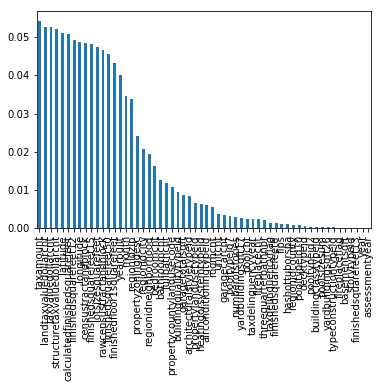

In [26]:
features=pd.Series(RF.feature_importances_,index=final_train_2.columns) #print best features
features.sort_values(ascending=False).plot(kind='Bar')